## 2.2 UM-Bridge Integration with QMC

In this section, we provide the UM-Bridge integration for a QMC client, similar to the MC client you have seen [before](https://github.com/MathSEE-Modeling-Week/Modeling-Week/blob/main/UQ/Monte_Carlo/MC_client.ipynb). To get started, you need to run the [model server](https://github.com/MathSEE-Modeling-Week/Modeling-Week/blob/main/UQ/Monte_Carlo/MC_server.ipynb), and then you can make a client request by executing the following code.

In [10]:
import numpy as np
import umbridge
from scipy.stats.qmc import Sobol

model = umbridge.HTTPModel("http://localhost:4242", "forward")

N = 100 # Number of samples

## Quasi Monte Carlo simulation

# Generate N Sobol sequence samples and convert them to a list
sobol_engine = Sobol(d=1, scramble=True) # initialize the Sobol sequence generator
parameters = sobol_engine.random(N).tolist()
print("First ten parameters:", parameters[:10], "\n") # print first 10 parameters

qmc_values = [model([parameters])[0][0] for parameters in parameters]  # model evaluation for each parameter
print("First ten model evaluations:", qmc_values[:10], "\n")

qmc_mean = np.mean(qmc_values)  # calculate mean
print("QMC estimator:", qmc_mean, "\n")

First ten parameters: [[0.08197019342333078], [0.967562111094594], [0.6506428066641092], [0.2728481153026223], [0.4979884885251522], [0.6101983403787017], [0.801137282513082], [0.18113017454743385], [0.20835448056459427], [0.8364163069054484]] 

First ten model evaluations: [0.49256436468190323, -0.2024051328198409, -0.811384379598414, 0.9897131002920818, 0.012638362869275438, -0.6383837153384229, -0.9488240935612094, 0.9078277136150216, 0.9659602075593827, -0.8561780874177579] 

QMC estimator: 0.005911264884264689 



---

### Understanding the Results

- **Quasi Monte Carlo Estimator**: Instead of using purely random sampling like in the MC method, the QMC method uses the Sobol sequence, which is a low-discrepancy sequence designed to fill the space more uniformly. The mean of the model evaluations provides the QMC estimator.
  
- **Sample Size**: Just as with standard MC, increasing $N$ improves the accuracy of the QMC estimator. The QMC method, however, typically converges faster than Monte Carlo with an error rate of $\mathcal{O}(N^{-1})$, provided the function is smooth.

---

## Tasks

1. **Estimate Another Integral**: If you want to estimate another integral, modify the `Testmodel` class in the model server as shown [here](https://github.com/MathSEE-Modeling-Week/Modeling-Week/blob/main/UQ/MC_server.ipynb). Change the definition of `posterior` to evaluate a different 1D function. How does the QMC method perform for different functions compared to the MC method?

2. **Extend to Higher Dimensions**: For higher-dimensional functions, adjust the input and output sizes in the [Testmodel class](https://github.com/MathSEE-Modeling-Week/Modeling-Week/blob/main/UQ/MC_server.ipynb) and modify the client code to generate Sobol sequences for higher dimensions (e.g., `Sobol(d=2)` for a 2D function). How does the QMC estimator behave when applied to higher-dimensional problems?

3. **Application to Other Models via UM-Bridge**: Use the QMC method to sample for example initial conditions and apply these to another model (e.g., an ODE system) via the UM-Bridge framework. Calculate the mean results of the model outputs for QMC samples and compare them to the expected behavior of the system.

Below, you can find an example solution for task 3 and the predator prey model.

---


<br><br><br><br><br><br><br><br>

<br><br><br><br><br><br><br><br>


## Example Solution

### 3. Application to Other Models (UM-Bridge Integration)

Next, we apply the QMC method to another team's model using the **UM-Bridge** framework. This model could represent any system, such as a predator-prey dynamical system or an ODE. 

We follow these steps:
- Use a Sobol sequence to generate perturbed initial conditions.
- Solve the other team's model for each initial condition using UM-Bridge.
- Calculate the mean result of the model outputs and compare them to expected behavior.

In this case, we apply QMC to the predator-prey system, where the initial condition is perturbed according to a Sobol sequence.

Don't forget to [run your model](https://github.com/MathSEE-Modeling-Week/Modeling-Week/blob/main/UQ/predprey_server.ipynb).

#### Results

The histogram below shows the distribution of the results from the QMC simulation for the other model. The QMC mean is indicated, demonstrating the effectiveness of the method in this context.


QMC mean for other model at T=6: 1.5020057562882139
True value for unperturbed initial condition at T=6: 1.4098300518932472


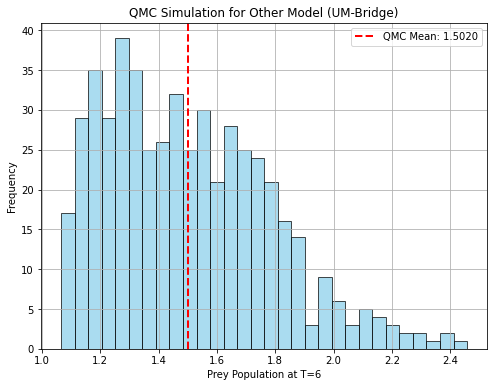

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import Sobol
import umbridge

# Define a UM-Bridge model for some other team's system (e.g., ODE model)
model = umbridge.HTTPModel("http://0.0.0.0:4242", "forward")

# Define parameters for the other model (based on the system's requirement)
T = 6
theta_values = [1.0, 1.0, 1.0, 1.0]
u0_bar = np.array([0.5, 2])
delta = 0.2

# Number of QMC samples
N = 512

# Generate QMC samples for perturbed initial conditions
sobol_engine = Sobol(d=2, scramble=True)
qmc_samples = sobol_engine.random(N)

# Use the samples to perturb the initial condition
initial_conditions = u0_bar + delta * (2 * qmc_samples - 1)

# Solve ODE for each initial condition using the UM-Bridge model
results = []
for u0 in initial_conditions:
    parameters = [T, u0[0], u0[1]] + theta_values
    result = model([parameters])
    results.append(result[0][0])  # Assuming we're interested in the prey population (u1) at T=6

# Calculate mean and plot results
qmc_mean_umbridge = np.mean(results)
print(f"QMC mean for other model at T={T}: {qmc_mean_umbridge}")

# Solve ODE for unperturbed initial condition
parameters_unperturbed = [T, u0_bar[0], u0_bar[1]] + theta_values
result_unperturbed = model([parameters_unperturbed])
true_value = result_unperturbed[0][0]
print(f"True value for unperturbed initial condition at T={T}: {true_value}")

# Plot the histogram of the results
plt.figure(figsize=(8, 6))
plt.hist(results, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(qmc_mean_umbridge, color='red', linestyle='dashed', linewidth=2, label=f'QMC Mean: {qmc_mean_umbridge:.4f}')
plt.title('QMC Simulation for Other Model (UM-Bridge)')
plt.xlabel('Prey Population at T=6')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()